LETTERS + DIGITS
Train:  (184800, 28, 28)
Test:  (30800, 28, 28)
Train labels:  (184800,)
Test labels:  (30800,)
Epoch 1/15
9240/9240 [==============================] - 35s 2ms/step - loss: 1.0559 - accuracy: 0.6558 - val_loss: 0.5058 - val_accuracy: 0.8272
Epoch 2/15
9240/9240 [==============================] - 20s 2ms/step - loss: 0.5751 - accuracy: 0.8066 - val_loss: 0.4286 - val_accuracy: 0.8485
Epoch 3/15
9240/9240 [==============================] - 20s 2ms/step - loss: 0.5004 - accuracy: 0.8315 - val_loss: 0.3989 - val_accuracy: 0.8607
Epoch 4/15
9240/9240 [==============================] - 20s 2ms/step - loss: 0.4624 - accuracy: 0.8427 - val_loss: 0.3835 - val_accuracy: 0.8700
Epoch 5/15
9240/9240 [==============================] - 20s 2ms/step - loss: 0.4380 - accuracy: 0.8528 - val_loss: 0.3854 - val_accuracy: 0.8699
Epoch 6/15
9240/9240 [==============================] - 20s 2ms/step - loss: 0.4236 - accuracy: 0.8568 - val_loss: 0.3704 - val_accuracy: 0.8736
Epoch 7/15
9240/9

c:\Users\rkbij\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


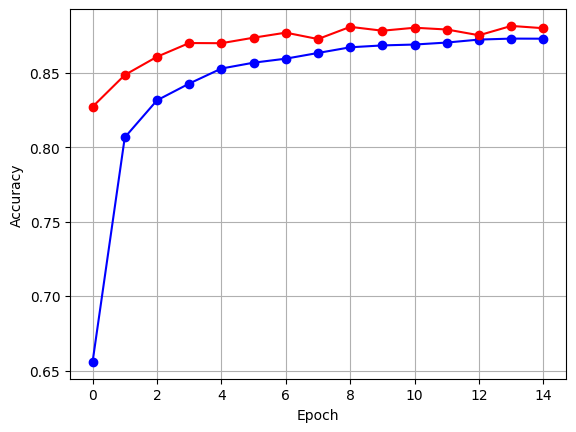

In [3]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from emnist import extract_training_samples, extract_test_samples
from sklearn.model_selection import train_test_split
tf.get_logger().setLevel('ERROR')

INPUT_SIZE = 28
BATCH_SIZE = 16
NUMBER_OF_CLASSES = 36
EPOCHS = 15

digits_model = tf.keras.models.load_model('./model/digits.h5')

train_letters, train_letters_labels = extract_training_samples('letters')
test_letters, test_letters_labels = extract_test_samples('letters')

train_digits, train_digits_labels = extract_training_samples('mnist')
test_digits, test_digits_labels = extract_test_samples('mnist')

train_letters_labels = train_letters_labels + 9
test_letters_labels = test_letters_labels + 9

train_combined = np.concatenate([train_digits, train_letters], axis=0)
train_labels_combined = np.concatenate([train_digits_labels, train_letters_labels], axis=0)

test_combined = np.concatenate([test_digits, test_letters], axis=0)
test_labels_combined = np.concatenate([test_digits_labels, test_letters_labels], axis=0)

print("LETTERS + DIGITS")
print('Train: ',train_combined.shape)
print('Test: ',test_combined.shape)
print('Train labels: ',train_labels_combined.shape)
print('Test labels: ',test_labels_combined.shape)

train_combined = train_combined / 255.0
test_combined = test_combined / 255.0

train_labels_combined = to_categorical(train_labels_combined, num_classes=NUMBER_OF_CLASSES)
test_labels_combined = to_categorical(test_labels_combined, num_classes=NUMBER_OF_CLASSES)

model_combined = Sequential()
model_combined.add(digits_model)
model_combined.add(Flatten())
model_combined.add(Dense(512, activation='relu'))
model_combined.add(Dropout(0.5))
model_combined.add(Dense(NUMBER_OF_CLASSES, activation='softmax'))

model_combined.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

combined_train_images, combined_test_images, combined_train_labels, combined_test_labels = train_test_split(
    train_combined, train_labels_combined, test_size=0.2, random_state=42
)

combined_train_images = np.expand_dims(combined_train_images, axis=-1)
combined_test_images = np.expand_dims(combined_test_images, axis=-1)

combined_train_images = np.repeat(combined_train_images, 3, axis=-1)
combined_test_images = np.repeat(combined_test_images, 3, axis=-1)

combined_train_images = np.array([cv2.resize(image, (INPUT_SIZE, INPUT_SIZE)) for image in combined_train_images])
combined_test_images = np.array([cv2.resize(image, (INPUT_SIZE, INPUT_SIZE)) for image in combined_test_images])

history = model_combined.fit(combined_train_images, combined_train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(combined_test_images, combined_test_labels))

x = range(EPOCHS)
plt.grid(True)
plt.plot(x, history.history['accuracy'], 'bo-', label='Training accuracy')
plt.plot(x, history.history['val_accuracy'], 'ro-', label='Testing accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

model_combined.save('./model/letters_and_digits.h5')

HANDWRITTEN TEXT (DIGITS+LETTERS) RECOGNITION

In [4]:
import os
import numpy as np
import tensorflow as tf
from process_image import preprocess_image
from sklearn.metrics import accuracy_score

INPUT_SIZE = 28

combined_model = tf.keras.models.load_model('./model/letters_and_digits.h5')
message = list('MAKSYMKLISHOVITPM23035468971')
data_path = './data/all_symbols'
image_path = os.listdir(data_path)
indexes = [int(indx.replace('.jpg','')) for indx in image_path]
indexes.sort()
symbols = []

for idx in indexes:
    symbols.append(preprocess_image(data_path+'/'+str(idx)+'.jpg', INPUT_SIZE))

written_text = []
for letter in symbols:
    predictions = combined_model.predict(letter)
    predicted_class_index = np.argmax(predictions[0])
    if predicted_class_index < 10:
        recognized_character = str(predicted_class_index)
    else:
        recognized_character = chr(ord('A') + (predicted_class_index - 10))
    written_text.append(recognized_character)

print(f"\nAccuracy: {accuracy_score(message, written_text)* 100:.2f}%")
print("Recognized characters:", ' '.join(written_text))
print('Desired characters:   ', ' '.join(message))

1/1 [==============================] - 0s 13ms/step

Accuracy: 71.43%
Recognized characters: M A K S Y M K L J J H U V I T P M Z 3 0 3 5 4 G 8 J T T
Desired characters:    M A K S Y M K L I S H O V I T P M 2 3 0 3 5 4 6 8 9 7 1
